In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
from tqdm import tqdm
import torch
import os
import open_clip

c:\Users\gears\Desktop\TripTrack\ai-research\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Funções de utilidade

In [2]:


# Modelo CLIP (OpenCLIP)
CLIP_MODEL_NAME = "ViT-B-32"
CLIP_PRETRAINED = "openai"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


def listar_imagens_com_label(images_dir):
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}
    image_paths = []
    labels = []

    for root, _, files in os.walk(images_dir):
        for f in files:
            if os.path.splitext(f.lower())[1] in exts:
                full = os.path.join(root, f)
                label = os.path.basename(root)  # nome da pasta
                image_paths.append(full)
                labels.append(label)

    return image_paths, labels

def carregar_imagem(path):
    try:
        return Image.open(path).convert("RGB")
    except:
        return None


def carregar_clip():
    print(f"\n🔄 Carregando modelo CLIP {CLIP_MODEL_NAME} ({CLIP_PRETRAINED})...")
    model, preprocess,_ = open_clip.create_model_and_transforms(
        CLIP_MODEL_NAME,
        pretrained=CLIP_PRETRAINED
    )
    tokenizer = open_clip.get_tokenizer(CLIP_MODEL_NAME)
    model = model.to(DEVICE)
    model.eval()
    print("✅ Modelo carregado\n")
    return model, preprocess, tokenizer


def gerar_text_embeddings(model, tokenizer, prompts):
    with torch.no_grad():
        tokens = tokenizer(prompts).to(DEVICE)
        emb = model.encode_text(tokens)
        emb = emb / emb.norm(dim=-1, keepdim=True)
    return emb



def gerar_image_embeddings(model, preprocess, imgs):
    tensor = torch.stack([preprocess(i) for i in imgs]).to(DEVICE)
    with torch.no_grad():
        emb = model.encode_image(tensor)
        emb = emb / emb.norm(dim=-1, keepdim=True)
    return emb


def calcular_similaridade(image_emb, text_emb):
    similarity = (100.0 * image_emb @ text_emb.T).softmax(dim=-1)
    return similarity.cpu().numpy()

## Preparação dos labels para geração de embeddings

In [4]:


VIBES_LABELS =[
   "Confident",
    "Determined",
    "Nostalgic",
    "Reflective",
   "Euphoric",
    "Energetic",
   "Calm",
    "Melancholic",
]

VIBE_PROMPT = [f"A photograph that evokes a deep sense of {vibe.lower()}, capturing the mood and atmosphere associated with it." for vibe in VIBES_LABELS]



IMAGES_DIR = "dataset/Spaces/train"

# Arquivo CSV final
OUTPUT_CSV = "vibes_imagens.csv"


# Batch size
BATCH_SIZE = 16


## Geração de Embeddings

In [6]:


print("Coletando imagens...")
image_paths, scene_labels = listar_imagens_com_label(IMAGES_DIR)


model, preprocess, tokenizer = carregar_clip()

print("Calculando embeddings das vibes...")
text_emb = gerar_text_embeddings(model, tokenizer, VIBE_PROMPT)
print("OK!\n")

Coletando imagens...

🔄 Carregando modelo CLIP ViT-B-32 (openai)...


c:\Users\gears\Desktop\TripTrack\ai-research\venv\Lib\site-packages\open_clip\factory.py:450: UserWarning: QuickGELU mismatch between final model config (quick_gelu=False) and pretrained tag 'openai' (quick_gelu=True).
  warnings.warn(


✅ Modelo carregado

Calculando embeddings das vibes...
OK!



### Processamento das linhas musicais para criação dos embeddings

In [29]:
# Resultados
df_paths = []
df_labels = []
df_vibes = []
df_scores = []

print("🖼️ Processando imagens e atribuindo vibe...\n")

for start in tqdm(range(0, len(image_paths), BATCH_SIZE)):
    end = min(start + BATCH_SIZE, len(image_paths))
    batch_indices = range(start, end)

    imgs = []
    idx_valid = []

    # carregar imagens
    for idx in batch_indices:
        img = carregar_imagem(image_paths[idx])
        if img is not None:
            imgs.append(img)
            idx_valid.append(idx)
        else:
            # imagem inválida
            df_paths.append(image_paths[idx])
            df_labels.append(scene_labels[idx])
            df_vibes.append(None)
            df_scores.append(None)

    if not imgs:
        continue

    # embeddings imagem
    img_emb = gerar_image_embeddings(model, preprocess, imgs)

    # similaridade imagem-texto
    scores = (img_emb @ text_emb.T).cpu().numpy()

    # para cada imagem válida
    j = 0
    for idx in batch_indices:
        if idx not in idx_valid:
            continue

        sc = scores[j]
        j += 1

        best_i = int(np.argmax(sc))
        best_vibe = VIBES_LABELS[best_i]
        best_score = float(sc[best_i])

        df_paths.append(image_paths[idx])
        df_labels.append(scene_labels[idx])
        df_vibes.append(best_vibe)
        df_scores.append(best_score)

# Criar dataframe final
df = pd.DataFrame({
    "image_path": df_paths,
    "scene_label": df_labels,
    "vibe": df_vibes,
    "score": df_scores,
})

df.to_csv(OUTPUT_CSV, index=False)

🖼️ Processando imagens e atribuindo vibe...



  0%|          | 22/112717 [00:23<33:48:02,  1.08s/it]


KeyboardInterrupt: 

## Teste com uma Imagem

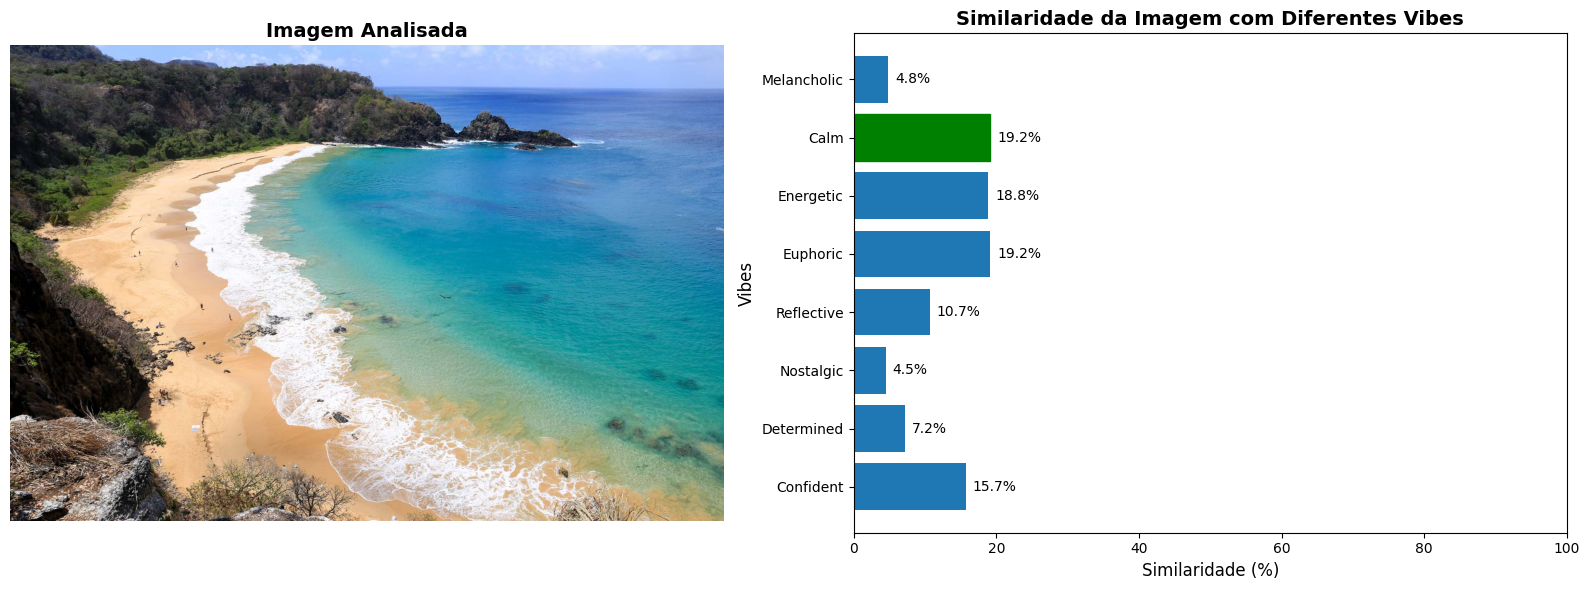


Vibe dominante: Calm (19.2%)


In [15]:
import matplotlib.pyplot as plt

image = carregar_imagem("./dataset/Praia.jpg")
image_emb = gerar_image_embeddings(model, preprocess, [image])

# Calcular similaridades
similarities = calcular_similaridade(image_emb, text_emb)[0]

# Criar figura com dois subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Imagem
ax1.imshow(image)
ax1.axis('off')
ax1.set_title('Imagem Analisada', fontsize=14, fontweight='bold')

# Subplot 2: Gráfico de barras
bars = ax2.barh(VIBES_LABELS, similarities * 100)

# Colorir a barra com maior similaridade
max_idx = np.argmax(similarities)
bars[max_idx].set_color('green')

ax2.set_xlabel('Similaridade (%)', fontsize=12)
ax2.set_ylabel('Vibes', fontsize=12)
ax2.set_title('Similaridade da Imagem com Diferentes Vibes', fontsize=14, fontweight='bold')
ax2.set_xlim(0, 100)

# Adicionar valores nas barras
for i, (vibe, sim) in enumerate(zip(VIBES_LABELS, similarities)):
    ax2.text(sim * 100 + 1, i, f'{sim * 100:.1f}%', va='center')

plt.tight_layout()
plt.show()

print(f"\nVibe dominante: {VIBES_LABELS[max_idx]} ({similarities[max_idx] * 100:.1f}%)")